# Introduction
## Research Question 

What is the information flow from visual stream to motor processing and how early in processing can we predict behavioural outcomes.
- Can decoding models be trained by region 
- How accurate are the modeled regions at predicting a behaviour 
- Possible behaviours (correct vs. incorrect) 
- Movement of wheel

## Brief background
The Steinmetz (2018) dataset reported that neurons with action correlates are found globally and that neurons in nearly every brain region are non-selectively activated in the moments leading up to movement onset, however it is currently not known how the information integration occurs across the motor areas and how that integration gives rise to motor behaviour.

Neuron population coding has been robustly used to decode motor behaviours across various species (Georgopoulos et al., 1986), and recent literature has suggested that motor preparation and planning uses distributed populations in corticomotor areas to plan motor movements. However this previous work has been limited by the number of electrodes and therefore areas measured in a single task.

The following assignment seeks to take advantage of the multi-array recording from the Steinmetz (2018) neuropixel data set to investigate temporal aspects of motor behaviours.

# Data Analyses
:brain: :mouse: :brain:

## Set Up

In [1]:
import pandas as pd
import numpy as np
import dataframe_image as dfi
import pathlib
from matplotlib import rcParams 
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [15, 5]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [2]:
import os, requests

fname = []
for i in range(3):
    fname.append('steinmetz_part%d.npz'%i)
url = ['https://osf.io/agvxh/download']
url.append('https://osf.io/uv3mw/download')
url.append('https://osf.io/ehmw2/download')

for i in range(len(url)):
    if not os.path.isfile(fname[i]):
        try:
            r = requests.get(url[i])
        except requests.ConnectionError:
            print("Data could not download!")
        else:
            if r.status_code != requests.codes.ok:
                print("Data could not download!")
            else:
                with open(fname[i], "wb") as fid:
                    fid.write(r.content)
                    

steinmetz_data = np.array([])
for i in range(len(fname)):
    steinmetz_data = np.hstack((steinmetz_data, np.load('steinmetz_part%d.npz'%i, allow_pickle=True)['dat']))

## Exploring the data

In [3]:
# choose one recording session (20) to get labels
session_20 = steinmetz_data[20]
keys = session_20.keys()
print(keys)

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


In [4]:
for key in session_20.keys():
    dataset_info = session_20[key]
    if isinstance (dataset_info, np.ndarray):
        print(key, dataset_info.shape, " - array")
    elif isinstance (dataset_info, list):
        print(key, len(dataset_info), " - list")
    else: 
        print(key, type(dataset_info), " - other")

spks (578, 124, 250)  - array
wheel (1, 124, 250)  - array
pupil (3, 124, 250)  - array
response (124,)  - array
response_time (124, 1)  - array
bin_size <class 'float'>  - other
stim_onset <class 'float'>  - other
contrast_right (124,)  - array
contrast_left (124,)  - array
brain_area (578,)  - array
feedback_time (124, 1)  - array
feedback_type (124,)  - array
gocue (124, 1)  - array
mouse_name <class 'str'>  - other
date_exp <class 'str'>  - other
trough_to_peak (578,)  - array
active_trials (194,)  - array
contrast_left_passive (70,)  - array
contrast_right_passive (70,)  - array
spks_passive (578, 70, 250)  - array
pupil_passive (3, 70, 250)  - array
wheel_passive (1, 70, 250)  - array
prev_reward (124, 1)  - array
ccf (578, 3)  - array
ccf_axes 3  - list
cellid_orig (795,)  - array
reaction_time (124, 2)  - array
face (1, 124, 250)  - array
face_passive (1, 70, 250)  - array
licks (1, 124, 250)  - array
licks_passive (1, 70, 250)  - array


In [5]:
brain_areas = []
for i in range(steinmetz_data.shape[0]):
    unique_area = np.unique(steinmetz_data[i]['brain_area']) # check this line for the 
    for u in unique_area:
        brain_areas.append(u)
ubs = list(np.unique(brain_areas))

In [10]:
table = pd.DataFrame(columns=['session', 'mouse_name', 'n_neuron'] + ubs)

for i in range(steinmetz_data.shape[0]):
    this_session: dict = {}
    unique_barea = list(np.unique(steinmetz_data[i]['brain_area']))
    this_session['session'] = i
    this_session['mouse_name'] = steinmetz_data[i]['mouse_name']
    this_session['n_neuron'] = steinmetz_data[i]['spks'].shape[0]
    this_session['n_trial'] = steinmetz_data[i]['spks'].shape[1]
    for ubrea in unique_barea:
        n_neuron, n_trial, _ = (steinmetz_data[i]['spks'][steinmetz_data[i]['brain_area'] == ubrea]).shape
        this_session[ubrea] = n_neuron

    table = table.append(this_session, ignore_index=True)
table = table.fillna(0)
pathlib.Path('/Users/sophiabatchelor/Code/SteinmetzAnalyses/Images').mkdir(parents=True, exist_ok=True)
dfi.export(table, '/Users/sophiabatchelor/Code/SteinmetzAnalyses/Images/steinmetz_all_data_table.png', max_cols=77)

In [ ]:
table

## Investigate Spiking Reponses

In [6]:
# groupings of brain regions
brain_regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groupings = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

In [7]:
mouse_dict = {} # create a dictionary 

for session, dat_i in enumerate(steinmetz_data):
    name = dat_i["mouse_name"]
    if name not in mouse_dict.keys():
        mouse_dict[name] = [dat_i]

    else:
        lst = mouse_dict[name]
        lst.append(dat_i)
        mouse_dict[name] = lst

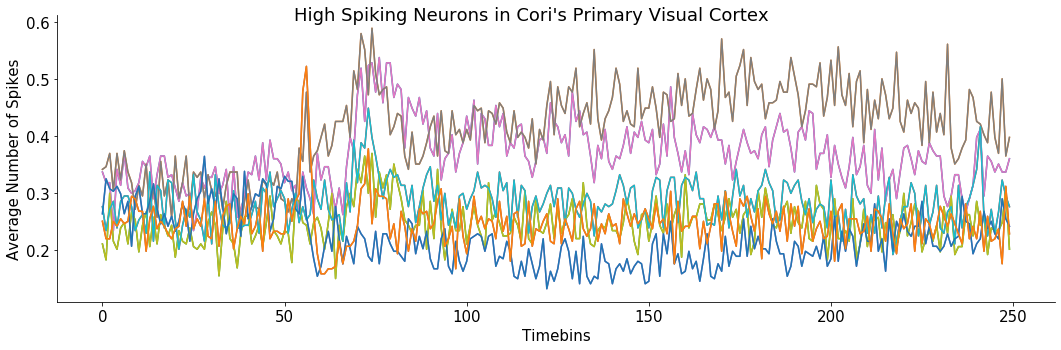

In [35]:
assigned_region = "VISp"


# analyse for all runs of a single mouse
for mouse in ["Cori"]:
    mouse_data =  mouse_dict[mouse] #list of the sessions corresponding to this mouse, [alldat[0], alldat[1], alldat[2]]
    num_sessions = len(mouse_dict[mouse])

    thing = None
    for trial in mouse_data:
        spk_trial = trial['spks']
        if assigned_region in trial["brain_area"]:
            spk_trial_region = spk_trial[trial["brain_area"] == assigned_region]

            # average over trials
            spk_trial_region_avg = np.mean(spk_trial_region, axis=1)

            # take only values that are average above 0.2
            spk_trial_region_avg_good = spk_trial_region_avg[np.mean(spk_trial_region_avg, axis=1) >= 0.2,:]

            if thing is not None:
                thing = np.concatenate((thing, spk_trial_region_avg_good))
            else:
                thing = spk_trial_region_avg_good

    plot = plt.figure()
    plt.plot(thing.T) 
    plot.suptitle("High Spiking Neurons in Cori's Primary Visual Cortex")
    plt.xlabel("Timebins")
    plt.ylabel("Average Number of Spikes")
    plt.savefig('/Users/sophiabatchelor/Code/SteinmetzAnalyses/Images/Plots/cori_v1_spks.png')
    plt.show(plot)

In [10]:
# Group The data by mouse
for session, dat_i in enumerate(steinmetz_data):
    name = dat_i["mouse_name"]
    if name not in mouse_dict.keys():
        mouse_dict[name] = [dat_i]

    else:
        lst = mouse_dict[name]
        lst.append(dat_i)
        mouse_dict[name] = lst

In [11]:
names = []
for dat_i in steinmetz_data:
    name = dat_i["mouse_name"]
    if name not in names:
        names.append(name)
print("Mice: {}".format(names))

Mice: ['Cori', 'Forssmann', 'Hench', 'Lederberg', 'Moniz', 'Muller', 'Radnitz', 'Richards', 'Tatum', 'Theiler']


In [12]:
assigned_regions = ['CA1', 'CA3',"VISp", "VISpm", "VISrl", "VISam", "VISa", "DG", "MD", "MOs", "MG", "MOp" ,]
    # change this to be whichever regions are of interest
    # !! NOTE !! the order matters

### Note ### 
# LIST OF AREAS 
# "VISp", "VISpm", "VISI", "VISrl", "VISam", "VISa", 'CA1', 'CA3', "DG", "CP", "SCm", "SCs", "SNr", "SSp", "ACA", "ILA", "GPe", "ACB", "APN", "BLA", "LD", "LGd", "LP", "LS", "MD", "MG", "MOp", "MOs", "MRN", "OLF", "ORB", "PAG", "PL", "PO", "POL", "POST", "RSP", "RT", "SUB", "ZI", "VPL", "VPM"
# VISI is throwing an error

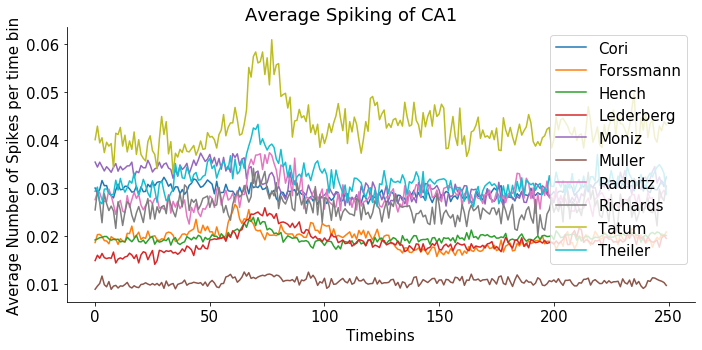

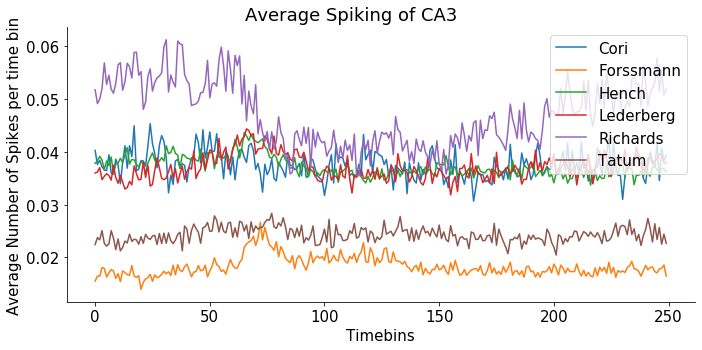

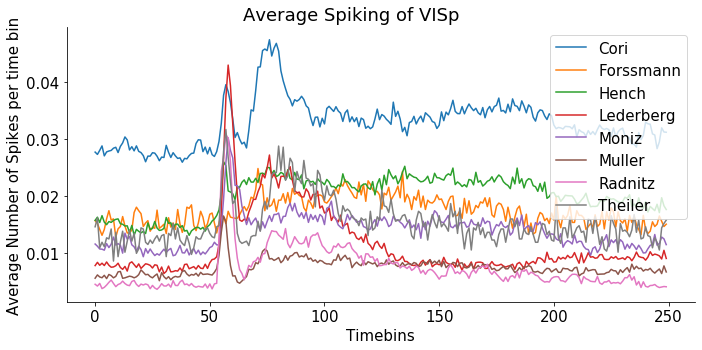

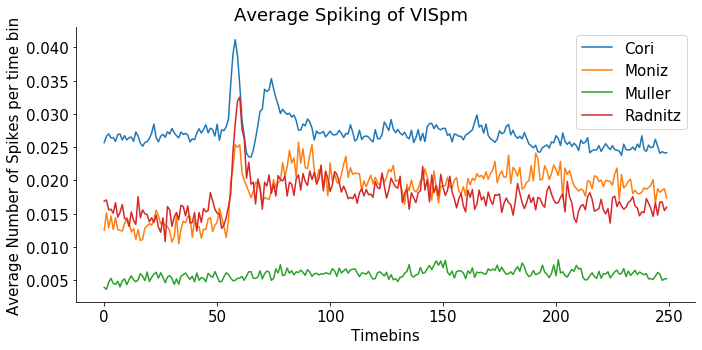

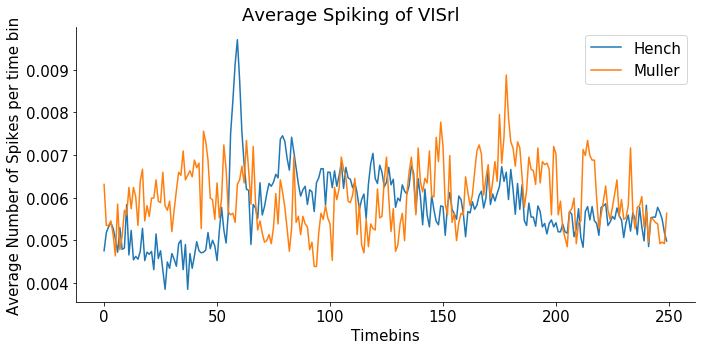

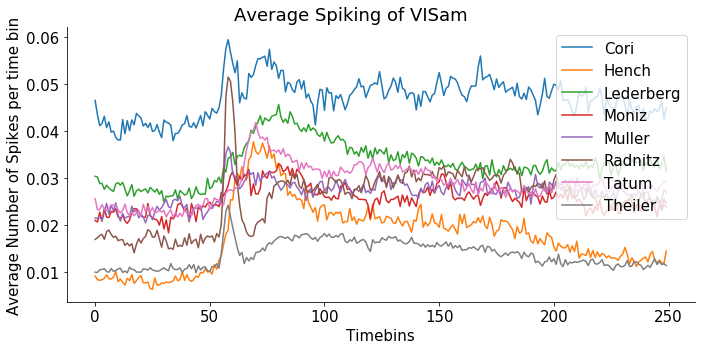

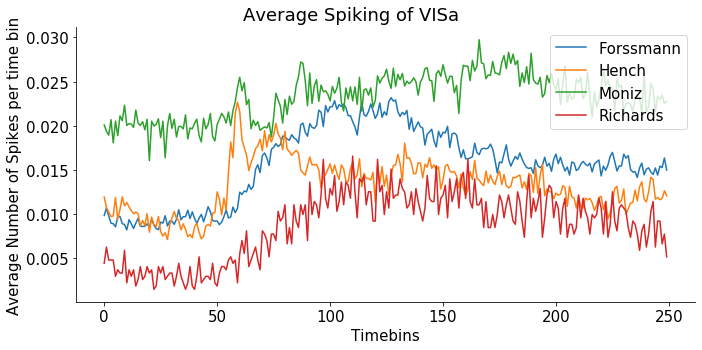

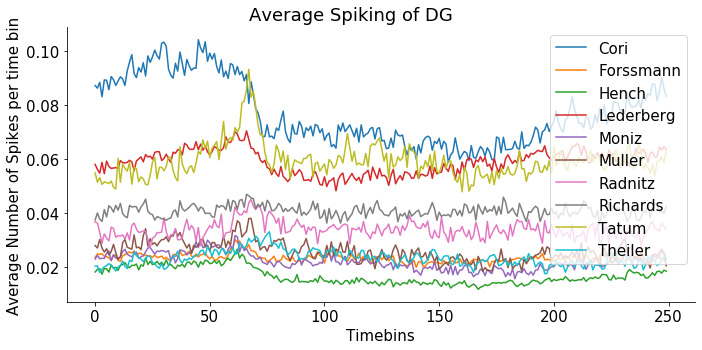

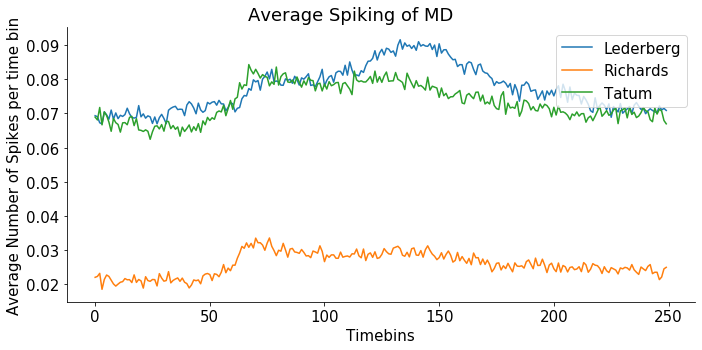

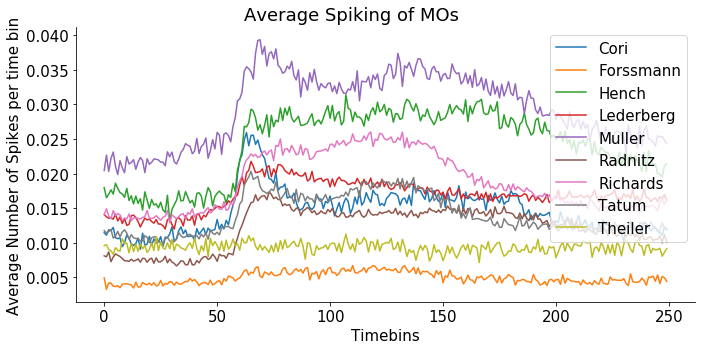

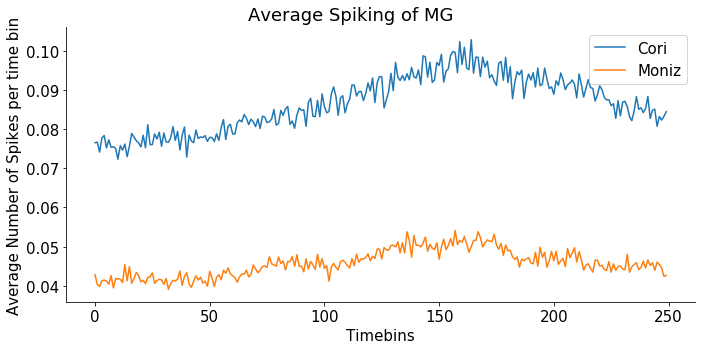

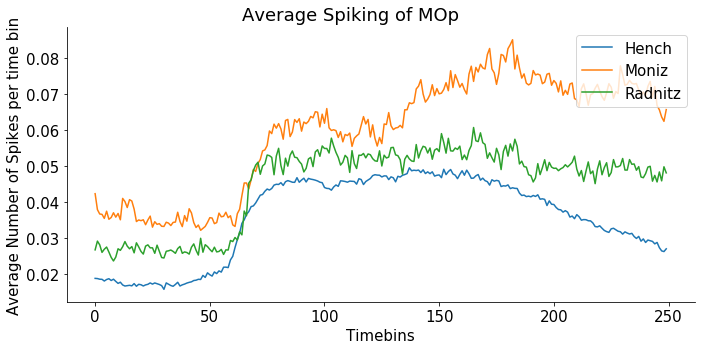

In [13]:
for assigned_region in assigned_regions:
    all_mice_names = []
    all_mice_lines = None

    for mouse in mouse_dict.keys():
        mouse_data = mouse_dict[mouse] 
        num_sessions = len(mouse_dict[mouse])

        spk_all_sessions = None
        
        for session in mouse_data:
            spk_session = session['spks']            
            if assigned_region in session['brain_area']:
                spk_session_region = spk_session[session['brain_area'] == assigned_region]

                # average over trials
                spk_session_region_avg = np.mean(spk_session_region, axis=1)

                if spk_all_sessions is not None:
                    spk_all_sessions = np.concatenate((spk_all_sessions, spk_session_region_avg))
                else:
                    spk_all_sessions = spk_session_region_avg
                    

        # average over all neurons
        if spk_all_sessions is not None:
            name_i = mouse
            all_mice_names.append(name_i)
            mouse_i = np.mean(spk_all_sessions, axis=0)
            mouse_i = np.expand_dims(mouse_i, 0)

            if all_mice_lines is not None:
                all_mice_lines = np.concatenate((all_mice_lines, mouse_i), axis = 0)
            else:
                all_mice_lines = mouse_i 

    plot = plt.figure(figsize=(10, 5))
    plt.plot(all_mice_lines.T) # had to transpose so that time was on the x axis 

    plot.suptitle("Average Spiking of {}".format(assigned_region))
    plt.xlabel("Timebins")  # change axis labels if you need reminders
    plt.ylabel("Average Number of Spikes per time bin")
    plt.legend(all_mice_names, loc = "upper right")
    pathlib.Path('/Users/sophiabatchelor/Code/SteinmetzAnalyses/Images/Plots').mkdir(parents=True, exist_ok=True)
    plt.savefig('/Users/sophiabatchelor/Code/SteinmetzAnalyses/Images/Plots/Plotof{}.png'.format(assigned_region))
    plt.show()

## Relationship between spiking and behaviour

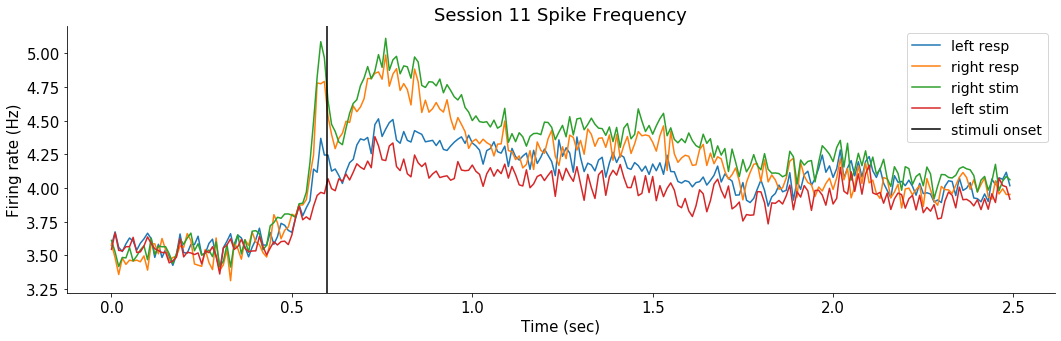

In [36]:
# analyses for Lederberg : session 11

session_11 = steinmetz_data[11]

dt = session_11['bin_size'] # 10ms bins
NT = session_11['spks'].shape[-1]

# ax = plt.subplot(1,5,1)
response = session_11['response'] # right - nogo - left (-1, 0, 1)
vis_right = session_11['contrast_right'] # 0 - low - high
vis_left = session_11['contrast_left'] # 0 - low - high
avg_gocue = (np.mean(session_11["gocue"]))


plt.plot(dt * np.arange(NT), 1 / dt * session_11['spks'][:,response>=0].mean(axis=(0,1))) # left responses
plt.plot(dt * np.arange(NT), 1 / dt * session_11['spks'][:,response<0].mean(axis=(0,1))) # right responses
plt.plot(dt * np.arange(NT), 1 / dt * session_11['spks'][:,vis_right>0].mean(axis=(0,1))) # right stimuli
plt.plot(dt * np.arange(NT), 1 / dt * session_11['spks'][:,vis_right==0].mean(axis=(0,1))) # left stimuli
plt.axvline(avg_gocue, color='black')

plt.title("Session 11 Spike Frequency")
plt.xlabel("Time (sec)")  # change axis labels if you need reminders
plt.ylabel("Firing rate (Hz)")
plt.legend(['left resp', 'right resp', 'right stim', 'left stim', 'stimuli onset'], fontsize=14)
pathlib.Path('/Users/sophiabatchelor/Code/SteinmetzAnalyses/Images/Plots/ResponseSpikeAnalyses').mkdir(parents=True, exist_ok=True)
plt.savefig('/Users/sophiabatchelor/Code/SteinmetzAnalyses/Images/Plots/ResponseSpikeAnalyses/session_11_spikes.png')

plt.show()


In [38]:
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

In [39]:
num_good_areas = 4 # only the top 4 regions are in this particular mouse
neurons = len(session_11['brain_area']) # gives the number of neurons
good_areas = num_good_areas * np.ones(neurons, ) # note: last brain region is "other"

for i in range(num_good_areas):
    good_areas[np.isin(session_11['brain_area'], brain_groups[i])] = i # assign a number to each region

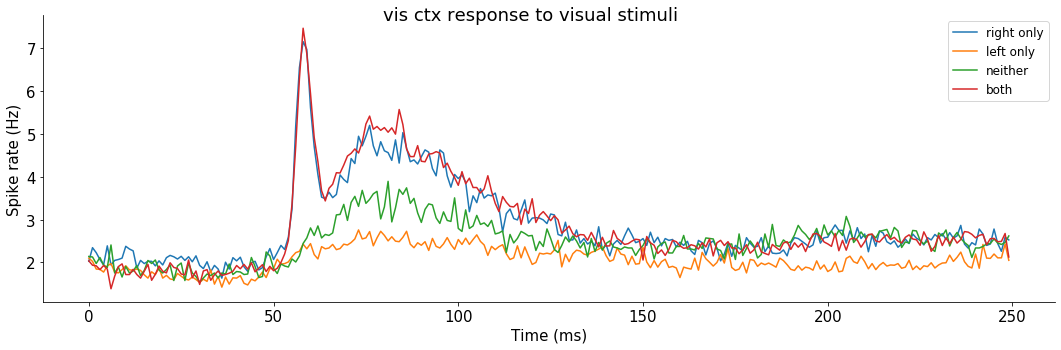

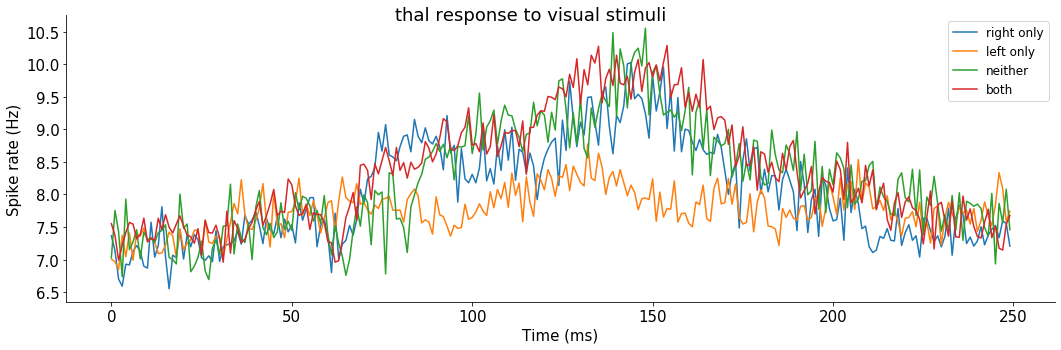

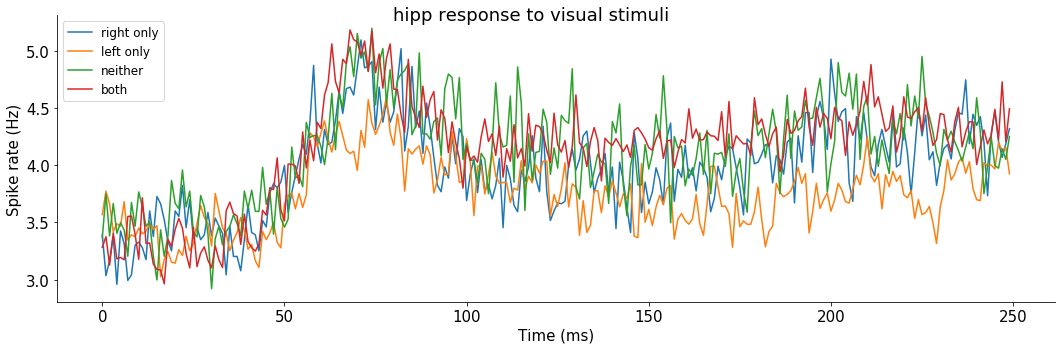

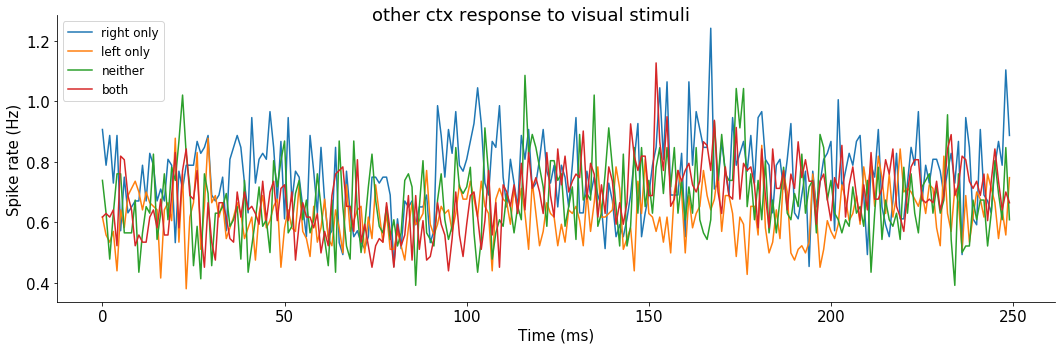

In [146]:
# Neural response to visual stimuli

for i in range(num_good_areas):
    fig, axs = plt.subplots(sharey = True)
    plt.plot(1 / dt * session_11['spks'][good_areas == i][:,np.logical_and(vis_left == 0, vis_right > 0)].mean(axis=(0,1)))
    plt.plot(1 / dt * session_11['spks'][good_areas == i][:,np.logical_and(vis_left == 0, vis_right == 0)].mean(axis=(0,1)))
    plt.plot(1 / dt * session_11['spks'][good_areas == i][:,np.logical_and(vis_left > 0, vis_right == 0)].mean(axis=(0,1)))
    plt.plot(1 / dt * session_11['spks'][good_areas == i][:,np.logical_and(vis_left > 0, vis_right > 0)].mean(axis=(0,1)))
    
    fig.suptitle('{} response to visual stimuli'.format(regions[i]))
    plt.xlabel('Time (ms)')
    plt.ylabel('Spike rate (Hz)')
    plt.legend(['right cue', 'left cue', 'no_cue', 'spike response any cue'], fontsize=12)
    plt.savefig('/Users/sophiabatchelor/Code/SteinmetzAnalyses/Images/Plots/ResponseSpikeAnalyses/session11_{}_vep.png'.format(regions[i]))